# Random Forest Regression İle modelleme

Genel olarak, Rondom Forest Regressor, iyi akort ettiğimizde iyi sonuçlar verir. Bu nedenle, basit temel modeli bulmak için bu defterde RandomForestRegressor kullanacağım. Ayrıca, model için özellik önemi bu defterde bulunabilir.

Bu proje için metriğimiz ağırlıklı ortalama mutlak hatadır (WMAE)

![title](metric.png)

where

- n is the number of rows
- ŷ i is the predicted sales
- yi is the actual sales
- wi are weights. w = 5 if the week is a holiday week, 1 otherwise

Bu metrik ile tatil haftalarındaki hata, normal haftalardan 5 kat daha fazla ağırlığa sahiptir. Bu nedenle tatil haftalarındaki satışları doğru tahmin etmek daha önemlidir.
Parkurlarla ilgili tüm sonuçlar bu defterin sonunda bulunabilir.

In [2]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

# For date-time
from datetime import datetime
from datetime import timedelta
import math

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor

In [3]:
pd.options.display.max_columns=100 # to see columns 

In [4]:
df = pd.read_csv('clean_data.csv')

In [5]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

# Encoding the Data 

Verilerimizi ön işleme için, tatil boolean değerlerini 0-1 olarak değiştireceğim ve mağazaların türünü A, B, C'den 1, 2, 3'e değiştireceğim.

In [10]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [11]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [12]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [13]:
df_encoded['Şükran Günü Haftası'] = df_encoded['Şükran Günü Haftası'].astype(bool).astype(int) # changing T,F to 0-1

In [14]:
df_encoded['İşçi Bayramı Haftası'] = df_encoded['İşçi Bayramı Haftası'].astype(bool).astype(int) # changing T,F to 0-1

In [15]:
df_encoded['Noel Haftası'] = df_encoded['Noel Haftası'].astype(bool).astype(int) # changing T,F to 0-1

In [16]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [17]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

## Özellikler Arasındaki Etkileşimlerin Gözlenmesi
İlk olarak, verilerimden bölünmüş tatil sütunlarını çıkaracağım ve onlarsız deneyeceğim. Şifrelenmiş verilerimi güvende tutmak için dataframe'imi yenisine atadım ve bunun için kullanacağım. 

In [18]:
drop_col = ['Super_Bowl','İşçi Bayramı Haftası','Şükran Günü Haftası','Noel Haftası']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

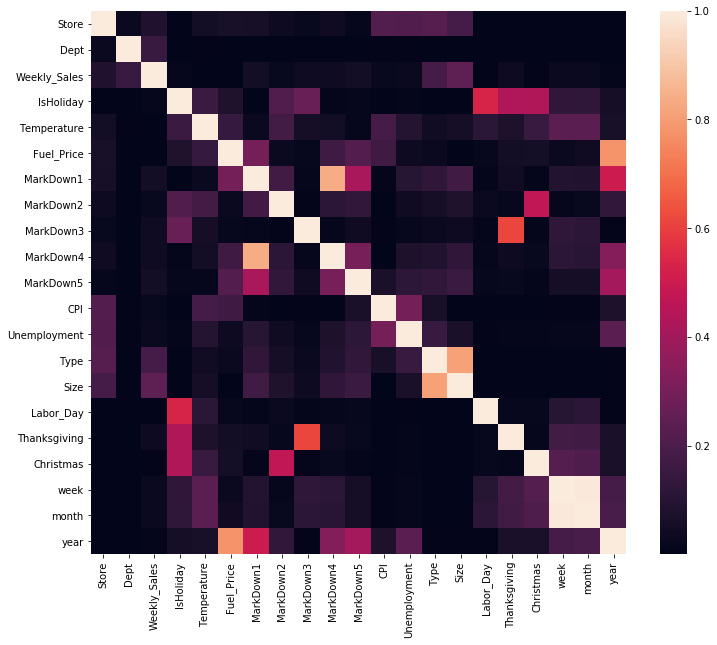

In [19]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Sıcaklık, işsizlik, TÜFE'nin haftalık satışlar üzerinde önemli bir etkisi yok, bu yüzden onları düşüreceğim. Ayrıca, Markdown 4 ve 5, Markdown 1 ile oldukça ilişkilidir. Bu yüzden onları da bırakacağım. Belki çoklu bağlantı sorunu yaratabilir. Yani, önce onlarsız deneyeceğim.

In [20]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

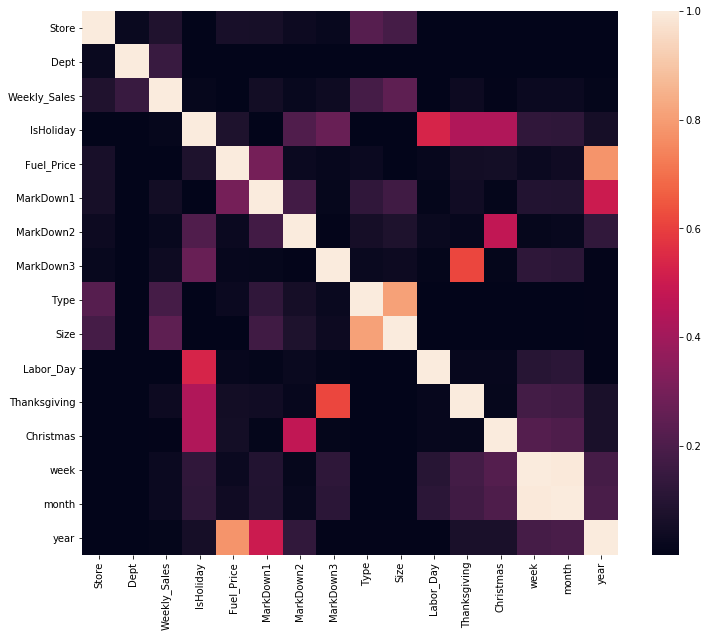

In [21]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Boyut ve tür, haftalık satışlarla yüksek oranda ilişkilidir. Ayrıca, departman ve mağaza satışlarla ilişkilidir.

In [22]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

## Eğitim-Test Bölmeleri Oluşturma
Tarih sütunumuz sürekli değerlere sahiptir, tarih özelliklerinin devam etmesi için rastgele bölme almayacağım. bu yüzden verileri %70'e göre manuel olarak böldüm

In [27]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.tolist() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [28]:
X = df_new[used_cols] # to keep train and test X values together

In [29]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

## Metrik Tanım Fonksiyonu
Metriğimiz, hazır modellerden varsayılan olarak hesaplanmaz. Tartılan hatadır, bu yüzden hesaplamak için aşağıdaki işlevi kullanacağım.

In [30]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

# Random Forest Regressor

Regresörü ayarlamak için gridsearch'ü kullanabilirim ancak çok sayıda satırı ve sütunu olan bu tür veriler için çok fazla zaman alır. Bu yüzden regresör parametrelerini manuel olarak seçiyorum. Her seferinde parametreleri değiştirdim ve en iyi sonucu bulmaya çalışıyoruz.

In [33]:
from sklearn.preprocessing import RobustScaler
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()

#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [34]:
wmae_test(y_test, y_pred_test)

6790.683944339376

İlk deneme için ağırlıklı hatam 6790 civarında.

# To See Feature Importance

In [35]:
X = X.drop(['Date'], axis=1) #dropping date column from X

Feature ranking:
1. feature 1 (0.744646)
2. feature 8 (0.105866)
3. feature 0 (0.052384)
4. feature 7 (0.033529)
5. feature 3 (0.020395)
6. feature 12 (0.018742)
7. feature 13 (0.007617)
8. feature 6 (0.005285)
9. feature 4 (0.003435)
10. feature 5 (0.002636)
11. feature 10 (0.001668)
12. feature 14 (0.001455)
13. feature 2 (0.001179)
14. feature 11 (0.000940)
15. feature 9 (0.000224)


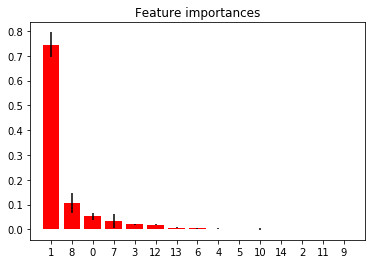

In [36]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [37]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

## Model Again without Month

In [38]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [39]:
wmae_test(y_test, y_pred_test)

6522.32654630462

# Model with Whole Data

Şimdi, modelimin bıraktığım veya almadığım sütunlardan öğreneceğinden emin olmak istiyorum. Bu yüzden modelimi tekrar tüm kodlanmış verilere uygulayacağım.

In [42]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.tolist() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [43]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [44]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [45]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [46]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [55]:
wmae_test(y_test_enc, y_pred_test_enc)

2450.1012493925496

Tüm veriler için daha iyi sonuçlar bulduk, bu, modelimizin daha önce bıraktığım sütunlardan öğrenebileceği anlamına geliyor.

#  Kodlanmış Veri Kümesi için Özelliğin Önemi

Feature ranking:
1. feature 1 (0.748272)
2. feature 13 (0.066092)
3. feature 12 (0.044216)
4. feature 0 (0.030377)
5. feature 10 (0.028143)
6. feature 11 (0.019932)
7. feature 21 (0.011474)
8. feature 3 (0.011397)
9. feature 4 (0.010242)
10. feature 22 (0.005565)
11. feature 7 (0.004647)
12. feature 9 (0.004469)
13. feature 8 (0.003510)
14. feature 5 (0.003403)
15. feature 6 (0.002682)
16. feature 23 (0.001446)
17. feature 19 (0.001081)
18. feature 2 (0.000864)
19. feature 16 (0.000650)
20. feature 17 (0.000445)
21. feature 18 (0.000401)
22. feature 14 (0.000284)
23. feature 15 (0.000208)
24. feature 20 (0.000202)


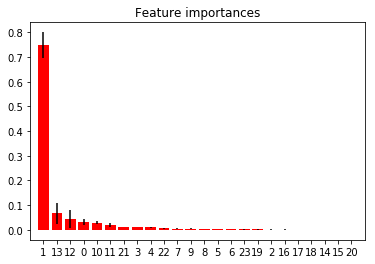

In [47]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [48]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

# Model According to Feature Importance

In [50]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.tolist() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [51]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [52]:
pipe.score(X_test_enc1,y_test_enc1)

0.7103568517542145

In [53]:
wmae_test(y_test_enc1, y_pred_test_enc)

2050.537720850406

Tüm kodlanmış veri kümesinden özellik seçimi yaparak en iyi sonuçları bulmus olduk.

## Ay Sütunlu Model
Daha önce aynı veri seti ile ay sütunu olmadan tekrar modellemeye çalışıyorum

In [54]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [55]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [56]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [58]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.tolist() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [59]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [60]:
pipe.score(X_test_enc2,y_test_enc2)

0.7323113161452579

In [61]:
wmae_test(y_test_enc2, y_pred_test_enc)

1962.0311041452821

In [62]:
df_results = pd.DataFrame(columns=["Model", "Info",'WMAE']) # result df for showing results together

In [63]:
# writing results to df
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out divided holiday columns' , 
       'WMAE' : 5850}, ignore_index=True)

In [64]:
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out month column' , 
       'WMAE' : 5494}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data' , 
       'WMAE' : 2450}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection' , 
       'WMAE' : 1801}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection w/out month' , 
       'WMAE' : 2093}, ignore_index=True)

In [65]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5850
1,RandomForestRegressor,w/out month column,5494
2,RandomForestRegressor,whole data,2450
3,RandomForestRegressor,whole data with feature selection,1801
4,RandomForestRegressor,whole data with feature selection w/out month,2093


En iyi sonuçlar, özellik seçimi ile tüm veri kümesine aittir. Şimdi 3.adım olan zaman serisi modellerini deneyeceğim.